In [1]:
!pip install sodapy

In [44]:
# importar as bibliotecas necessárias
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# import shelter official API
from sodapy import Socrata

In [3]:
client = Socrata("data.austintexas.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.austintexas.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9t4d-g238", limit=131000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

In [56]:
df.head()

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
0,A839115,*Libra,2021-09-19 18:53:00,2021-09-19T18:53:00.000,2021-04-16T00:00:00.000,Adoption,Cat,Spayed Female,5 months,Domestic Shorthair Mix,Black/White,NaN
1,A839116,Leo,2021-09-19 18:52:00,2021-09-19T18:52:00.000,2021-04-16T00:00:00.000,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair Mix,White/Black,NaN
2,A830449,Ruffy,2021-09-19 18:38:00,2021-09-19T18:38:00.000,2020-01-09T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Labrador Retriever/German Shepherd,Black,NaN
3,A837289,*Rainbow,2021-09-19 18:38:00,2021-09-19T18:38:00.000,2020-06-21T00:00:00.000,Adoption,Cat,Spayed Female,1 year,Domestic Shorthair,Brown Tabby,NaN
4,A840811,*Mango,2021-09-19 17:53:00,2021-09-19T17:53:00.000,2019-08-15T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Great Pyrenees Mix,Yellow,NaN


# Exploratory Analysis

In [13]:
# Getting data types and non-null values
print(df.info(), '\n\n')


# get summary of the main dataset statistics
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131000 entries, 0 to 130999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   animal_id         131000 non-null  object        
 1   name              90852 non-null   object        
 2   datetime          131000 non-null  datetime64[ns]
 3   monthyear         131000 non-null  object        
 4   date_of_birth     131000 non-null  object        
 5   outcome_type      130976 non-null  object        
 6   animal_type       131000 non-null  object        
 7   sex_upon_outcome  131000 non-null  object        
 8   age_upon_outcome  131000 non-null  object        
 9   breed             131000 non-null  object        
 10  color             131000 non-null  object        
 11  outcome_subtype   60218 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 12.0+ MB
None 




,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
count,131000,90852,131000,131000,131000,130976,131000,131000,131000,131000,131000,60218
unique,117143,21493,108608,108608,7359,9,5,6,53,2680,606,24
top,A721033,Max,2016-04-18 00:00:00,2016-04-18T00:00:00.000,2015-09-01T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Partner
freq,33,591,39,39,117,59143,73726,46079,22965,31734,13690,32263
first,NaN,NaN,2013-10-09 18:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-09-19 18:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Getting NaN values
df.isnull().sum().sort_values(ascending=False)

outcome_subtype     70782
name                40148
outcome_type           24
color                   0
breed                   0
age_upon_outcome        0
sex_upon_outcome        0
animal_type             0
date_of_birth           0
monthyear               0
datetime                0
animal_id               0
dtype: int64

In [15]:
# Checking all outcomes possible
print(f"OUTCOME TYPES: \n{df['outcome_type'].value_counts()}  \n\n")

# Checking all animal types
print(f"ANIMAL TYPES: \n{df['animal_type'].value_counts()}")

OUTCOME TYPES: 
Adoption           59143
Transfer           38288
Return to Owner    22084
Euthanasia          8747
Died                1237
Rto-Adopt            781
Disposal             602
Missing               70
Relocate              24
Name: outcome_type, dtype: int64  


ANIMAL TYPES: 
Dog          73726
Cat          49652
Other         6981
Bird           617
Livestock       24
Name: animal_type, dtype: int64


In [58]:
# Check only 'Adoption' and 'Return to Owner' outcomes
adoptions_df = df[(df['outcome_type'] == 'Adoption') | (df['outcome_type'] == 'Return to Owner')]
adoptions_df['outcomeCount'] = 1
adoptions_df = adoptions_df.set_index('datetime').sort_index()

# Checking all animal types
print(f"Adopted or returned to owner by Animal Type: \n{adoptions_df['animal_type'].value_counts()}\n\n")

# first and last dataset dates
print(f"First Date: {adoptions_df.index.min().strftime('%d %b %Y')}")
print(f"Last Date: {adoptions_df.index.max().strftime('%d %b %Y')}\n")

Adopted or returned to owner by Animal Type: 
Dog          54905
Cat          25404
Other          655
Bird           246
Livestock       17
Name: animal_type, dtype: int64


First Date: 09 Oct 2013
Last Date: 19 Sep 2021



Other animals, birds and livestock seems to be irrelevant to the total count, for this reason at least for now it will be used all animal types.

In [59]:
euthanasia_df = df[(df['outcome_type'] == 'Euthanasia')]
euthanasia_df['outcomeCount'] = 1
euthanasia_df = euthanasia_df.set_index('datetime').sort_index()

# Checking all animal types
print(f"Euthanasia by Animal Type: \n{euthanasia_df['animal_type'].value_counts()}\n\n")

Euthanasia by Animal Type: 
Other        4742
Cat          2052
Dog          1829
Bird          123
Livestock       1
Name: animal_type, dtype: int64




Here we can see that 'Other' Animals types are usually sacrificed. With visualization purposes and compare euthanasia and adoptions count, i will select only cats and dogs.

In [60]:
# Filtering by animal type
adoptions_df = adoptions_df.loc[(adoptions_df['animal_type'] == 'Cat') | (adoptions_df['animal_type'] == 'Dog')]
euthanasia_df = euthanasia_df.loc[(euthanasia_df['animal_type'] == 'Cat') | (euthanasia_df['animal_type'] == 'Dog')]

Now we will check daily and weekly data from euthanasia and adoptions subsets.

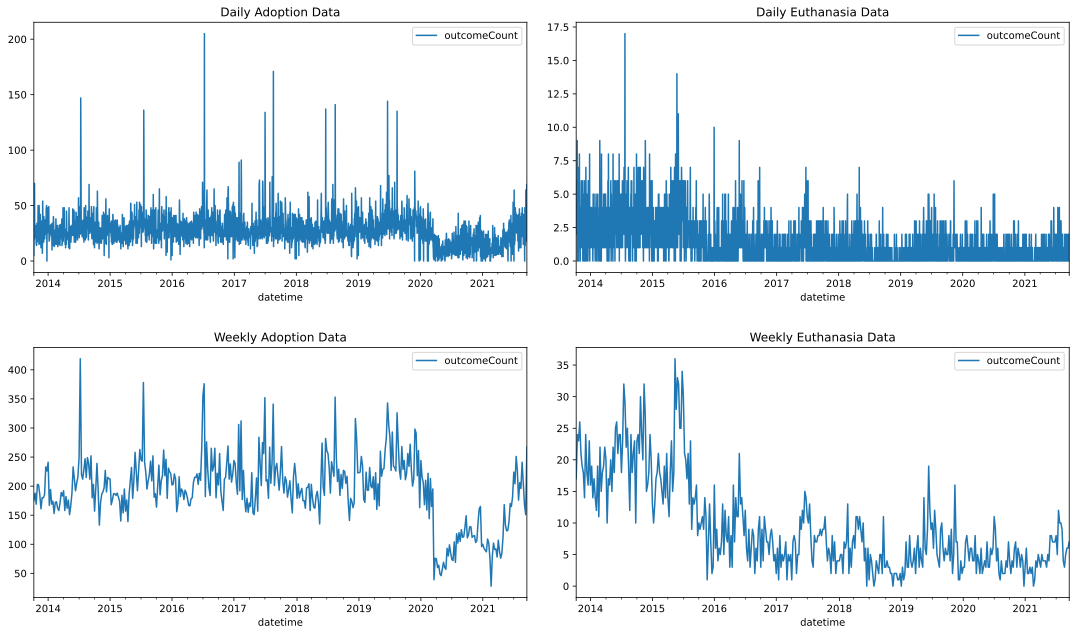

In [81]:
plt.rcParams["figure.figsize"] = (18,10)
fig1, axs = plt.subplots(nrows=2, ncols=2)

axs[0,0] = adoptions_df.resample('D').sum().plot(ax = axs[0,0], title='Daily Adoption Data')
axs[1,0] = adoptions_df.resample('W').sum().plot(ax = axs[1,0], title='Weekly Adoption Data')
axs[0,1] = euthanasia_df.resample('D').sum().plot(ax = axs[0,1], title='Daily Euthanasia Data')
axs[1,1] = euthanasia_df.resample('W').sum().plot(ax = axs[1,1], title='Weekly Euthanasia Data')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

While adoption numbers seems to be lower in 'covid' years, euthanasia numbers didn't change much. ( at least looking at data at charts )

---



Since one of the purposes of this work is to learn how to use Prophet, we need to make a time-series exploration.

Check autocorrelation is the first relation we want to look since it is a mathematical tool for finding repeating patterns. Because Prophet uses only the feature we want to predict as input, which means it relies on it's lagged values to forecast, meaning we need to check autocorrelation.

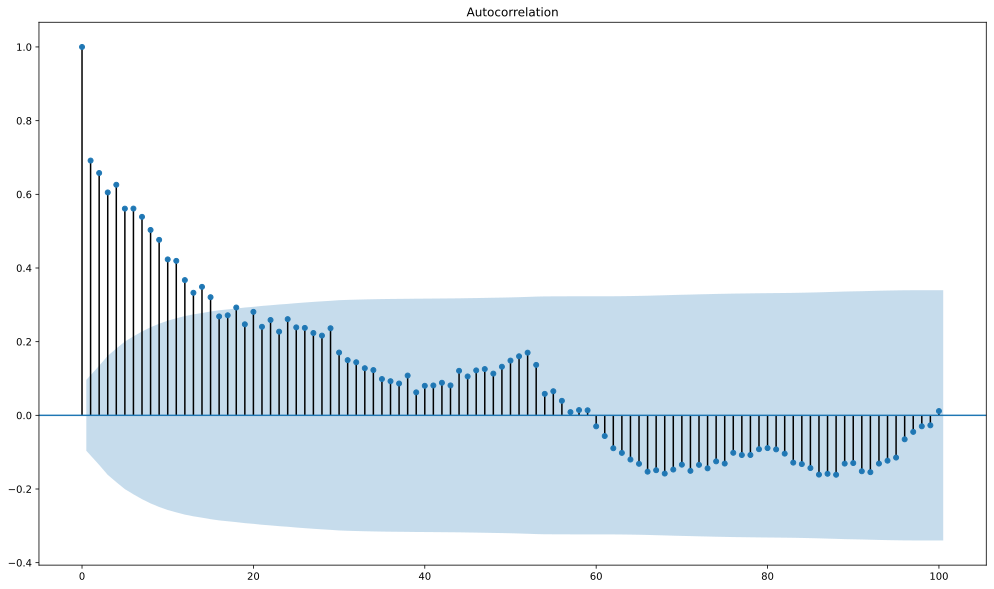

In [99]:
# Plot Autocorrelation
plt.rcParams["figure.figsize"] = (17,10)
plot_acf(adoptions_df[['outcomeCount']].resample('W').sum(), lags=100)
plt.show()

As Pandemic was a unexpected event and probably changed patterns in the short-term. I will get autocorrelation without 2020-2021 data.

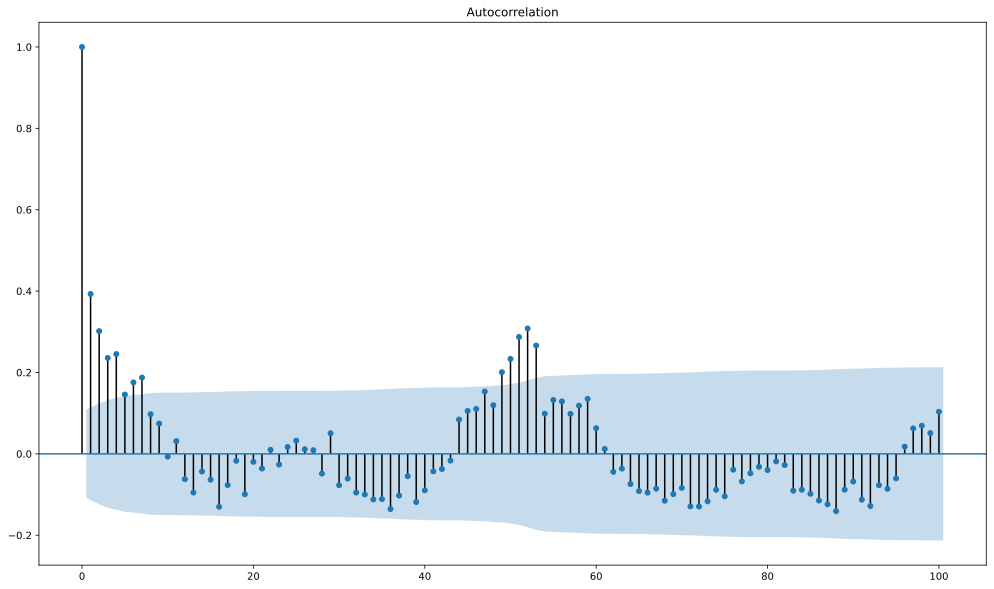

In [101]:
# Plot Autocorrelation
plt.rcParams["figure.figsize"] = (17,10)
plot_acf(adoptions_df.loc[:'2019'][['outcomeCount']].resample('W').sum(), lags=100)
plt.show()

It is confirmed that Covid data changed the autocorrelation analysis, we have to keep in mind this fact. Which means that for this exercise i will need to limit data.

The last date in the model input will be Dec 2018, so we can forecast 365 foward without forecasting pandemic dates.

---

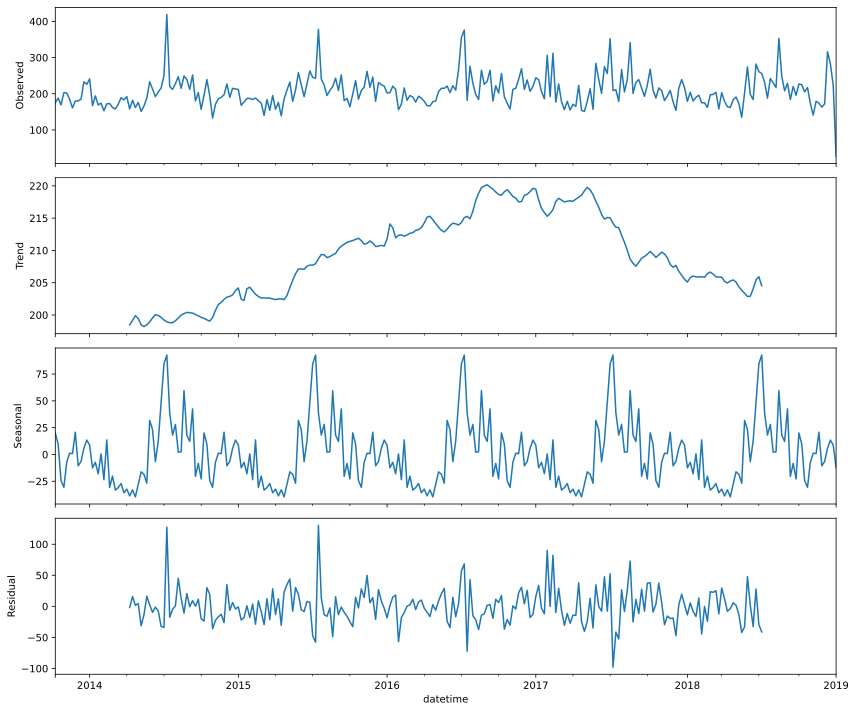

In [107]:
plt.rcParams["figure.figsize"] = (12,10)
res = seasonal_decompose(adoptions_df.loc[:'2018']['outcomeCount'].resample('W').sum())
res.plot();

# Preparing Data for Prophet input format

Prophet Documentation states that the input to Prophet is always a dataframe with two columns: ds and y
</br></br>
<strong>'ds' - datestamp column should be in the following formats:</strong>

- 'YYYY-MM-DD' format for dates
- 'YYYY-MM-DD HH:MM:SS' for a timestamp

</br>
<strong>'y' - this column must be numeric</strong>

In [108]:
# Initially work with daily data
prophet_df = adoptions_df.loc[:'2018'].resample('D').sum().reset_index().rename(columns={'datetime':'ds', 'outcomeCount':'y'})

# Check if we filtered correct
prophet_df.tail()

,ds,y
1905,2018-12-27,48
1906,2018-12-28,30
1907,2018-12-29,37
1908,2018-12-30,36
1909,2018-12-31,27


Seems ready to go.

# Creating Forecast model

## Daily Forecast

In [109]:
# instanciar e treinar o modelo
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(prophet_df)

# determinar o período de dias para previsão
future = model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


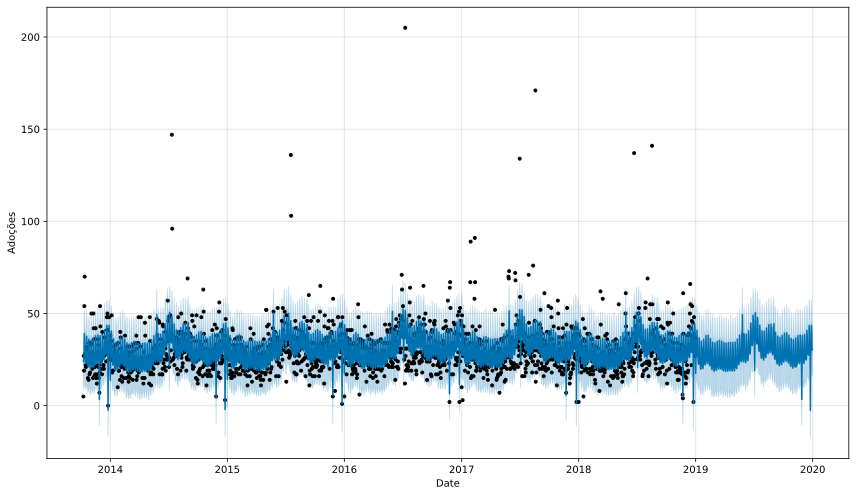

In [117]:
# visualizar o gráfico com as previsões
model.plot(forecast, xlabel='Date', ylabel='Adoções', figsize=(12,7));

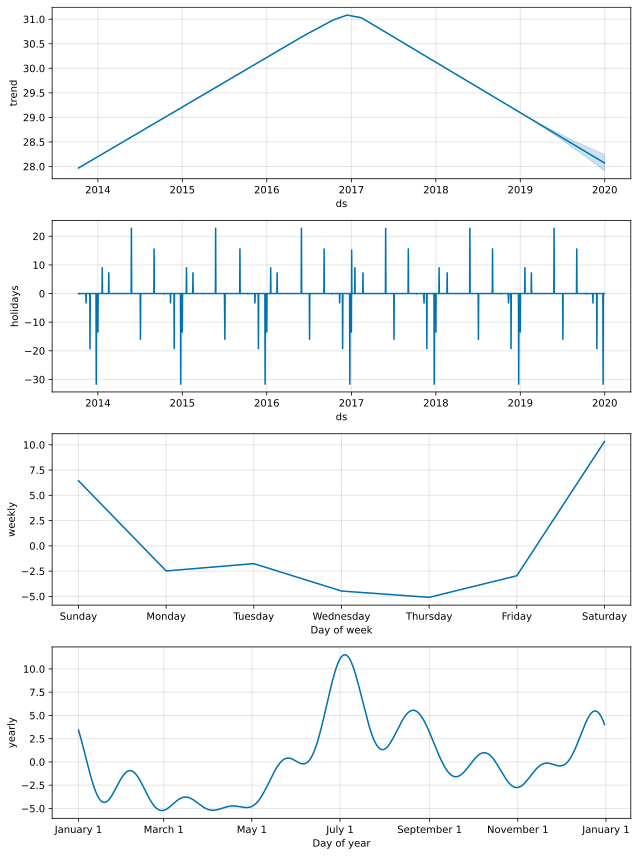

In [112]:
# separar os componentes do modelo
model.plot_components(forecast);

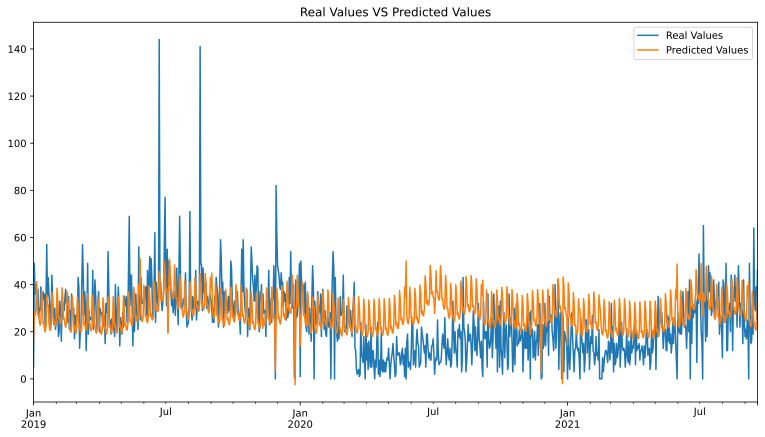

In [ ]:
results = pd.concat([adoptions_df.resample('D').sum()['outcomeCount'], y_test.set_index('ds')['yhat']],axis=1)
results.columns = ['Real Values', 'Predicted Values']

fig, ax = plt.subplots(figsize=(13,7))
plt.title('Real Values VS Predicted Values')
results.dropna().plot.line(ax=ax)
plt.show()


## Weekly forecast

In [118]:
# criar um modelo baseado em semanas
prophet_df2 = adoptions_df.loc[:'2018'].resample('W').sum().reset_index().rename(columns={'datetime':'ds', 'outcomeCount':'y'})

# instanciar e treinar o modelo
model2 = Prophet()
model2.add_country_holidays(country_name='US')
model2.fit(prophet_df2)

# determinar o período de dias para previsão
future2 = model2.make_future_dataframe(periods=52)

# realizar a previsão para o período estabelecido
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


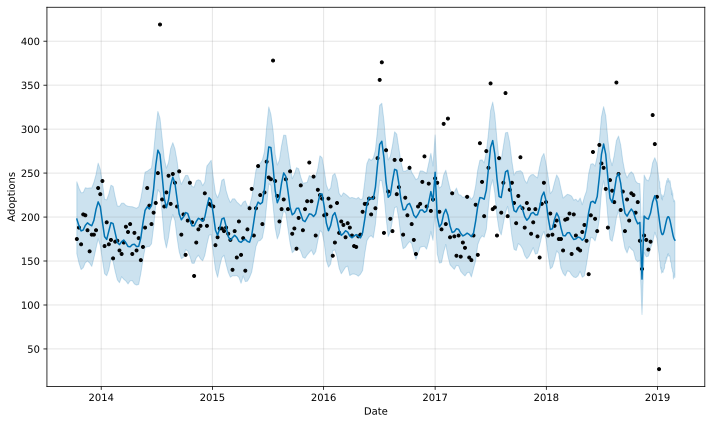

In [119]:
# visualizar o gráfico com as previsões
model2.plot(forecast2, xlabel='Date', ylabel='Adoptions');

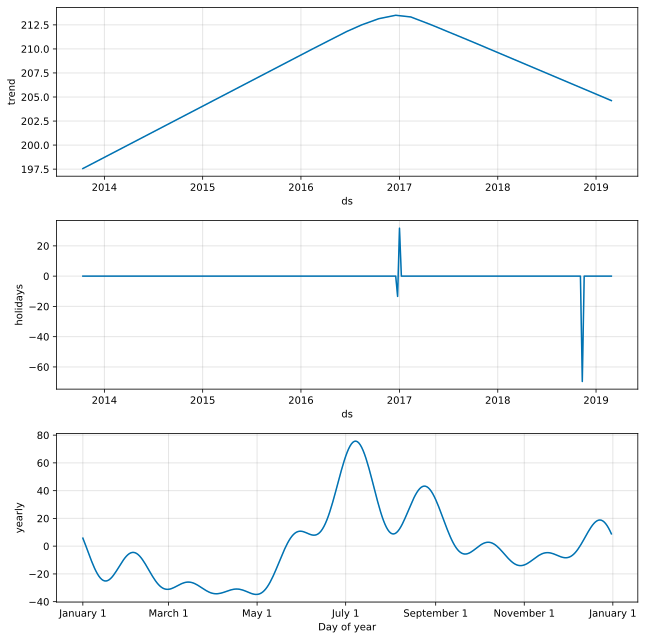

In [120]:
# separar os componentes do modelo
model2.plot_components(forecast2);

### Time-series evaluation

#### Model: Daily

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-01-11 00:00:00 and 2017-12-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

  horizon         mse       rmse       mae      mape     mdape  coverage
0 37 days  161.283797  12.699756  8.807253  0.373286  0.182799  0.751648
1 38 days  160.319405  12.661730  8.720000  0.345709  0.182799  0.756044
2 39 days  163.469511  12.785520  8.764428  0.343319  0.178685  0.756044
3 40 days  160.269829  12.659772  8.610156  0.337462  0.173338  0.762637
4 41 days  153.847289  12.403519  8.443866  0.328268  0.169934  0.775824 




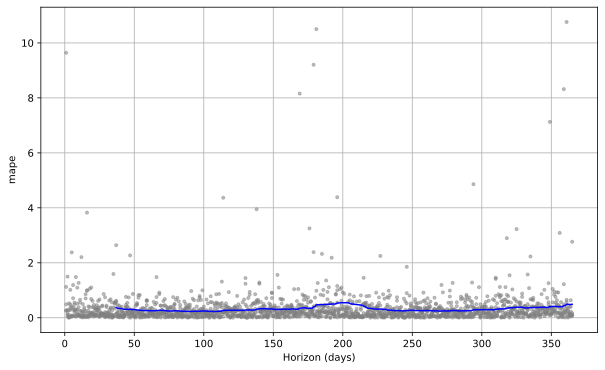

In [123]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')

df_p = performance_metrics(df_cv)

fig = plot_cross_validation_metric(df_cv, metric='mape')


print(df_p.head(), '\n\n')

#### Model: Weekly

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-01-17 00:00:00 and 2018-01-06 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

  horizon          mse       rmse        mae      mape     mdape  coverage
0 36 days  2890.761636  53.765804  37.379227  0.179524  0.097208  0.653846
1 37 days  2812.717217  53.035056  36.194784  0.171683  0.092108  0.692308
2 39 days  2052.091530  45.300017  31.509063  0.146059  0.092108  0.730769
3 41 days  2421.208725  49.205779  35.170799  0.156590  0.097208  0.692308
4 42 days  2088.013849  45.694790  32.302282  0.143306  0.097208  0.730769 



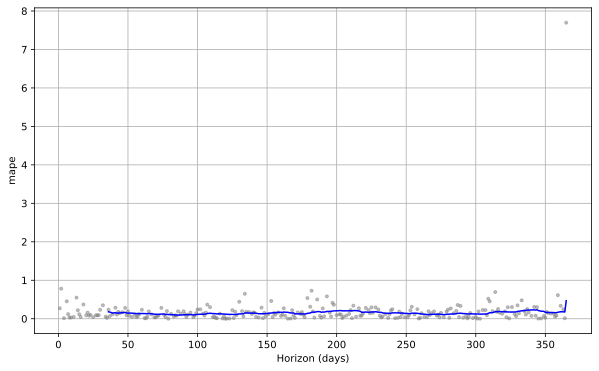

In [125]:

df_cv2 = cross_validation(model2,  initial='730 days', period='180 days', horizon = '365 days')
# print(df_cv2.head(), "\n")


df_p2 = performance_metrics(df_cv2)
print(df_p2.head(), "\n")


plot_cross_validation_metric(df_cv2, metric='mape');

# What Happened ?

In [ ]:
test = pd.read_csv('MEI_austin.csv'


,Unnamed: 0,Unnamed: 1,Unnamed: 2,"Abilene, TX","Akron, OH","Albany, GA","Albany-Lebanon, OR","Albany-Schenectady-Troy, NY","Albuquerque, NM","Alexandria, LA","Allentown-Bethlehem-Easton, PA-NJ","Altoona, PA","Amarillo, TX","Ames, IA","Anchorage, AK","Ann Arbor, MI","Anniston-Oxford, AL","Appleton, WI","Asheville, NC","Athens-Clarke County, GA","Atlanta-Sandy Springs-Alpharetta, GA","Atlantic City-Hammonton, NJ","Auburn-Opelika, AL","Augusta-Richmond County, GA-SC","Austin-Round Rock-Georgetown, TX","Bakersfield, CA","Baltimore-Columbia-Towson, MD","Bangor, ME","Barnstable Town, MA","Baton Rouge, LA","Battle Creek, MI","Bay City, MI","Beaumont-Port Arthur, TX","Beckley, WV","Bellingham, WA","Bend, OR","Billings, MT","Binghamton, NY","Birmingham-Hoover, AL","Bismarck, ND",...,"Texarkana, TX-AR","The Villages, FL","Toledo, OH","Topeka, KS","Trenton-Princeton, NJ","Tucson, AZ","Tulsa, OK","Tuscaloosa, AL","Twin Falls, ID","Tyler, TX","Urban Honolulu, HI","Utica-Rome, NY","Valdosta, GA","Vallejo, CA","Victoria, TX","Vineland-Bridgeton, NJ","Virginia Beach-Norfolk-Newport News, VA-NC","Visalia, CA","Waco, TX","Walla Walla, WA","Warner Robins, GA","Washington-Arlington-Alexandria, DC-VA-MD-WV","Waterloo-Cedar Falls, IA","Watertown-Fort Drum, NY","Wausau-Weston, WI","Weirton-Steubenville, WV-OH","Wenatchee, WA","Wheeling, WV-OH","Wichita, KS","Wichita Falls, TX","Williamsport, PA","Wilmington, NC","Winchester, VA-WV","Winston-Salem, NC","Worcester, MA-CT","Yakima, WA","York-Hanover, PA","Youngstown-Warren-Boardman, OH-PA","Yuba City, CA","Yuma, AZ"
0,NaN,All_MSAs,All_Rural,MSA_10180,MSA_10420,MSA_10500,MSA_10540,MSA_10580,MSA_10740,MSA_10780,MSA_10900,MSA_11020,MSA_11100,MSA_11180,MSA_11260,MSA_11460,MSA_11500,MSA_11540,MSA_11700,MSA_12020,MSA_12060,MSA_12100,MSA_12220,MSA_12260,MSA_12420,MSA_12540,MSA_12580,MSA_12620,MSA_12700,MSA_12940,MSA_12980,MSA_13020,MSA_13140,MSA_13220,MSA_13380,MSA_13460,MSA_13740,MSA_13780,MSA_13820,MSA_13900,...,MSA_45500,MSA_45540,MSA_45780,MSA_45820,MSA_45940,MSA_46060,MSA_46140,MSA_46220,MSA_46300,MSA_46340,MSA_46520,MSA_46540,MSA_46660,MSA_46700,MSA_47020,MSA_47220,MSA_47260,MSA_47300,MSA_47380,MSA_47460,MSA_47580,MSA_47900,MSA_47940,MSA_48060,MSA_48140,MSA_48260,MSA_48300,MSA_48540,MSA_48620,MSA_48660,MSA_48700,MSA_48900,MSA_49020,MSA_49180,MSA_49340,MSA_49420,MSA_49620,MSA_49660,MSA_49700,MSA_49740
1,03-Jan-2020,-20.6855068672483,-16.6530213986525,-26.1236008206069,-21.4320120785509,-34.7591674519545,-15.8269329816134,-14.9600256781323,-23.2283023819629,-29.6984532888841,-13.0364631898841,-0.306994944657525,-21.7451899443423,19.5014303189774,-32.0175685015377,-9.2012709957156,-52.9212266727037,-3.57154829023578,-11.9172214661568,-22.881647538492,-34.1303736122655,-6.51927887261429,-34.4099854601866,-27.6363308552744,-24.0310417279301,-21.8034751648425,-11.6748285835041,6.4968280821879,-6.60383512498972,-29.4584462635579,-25.0088973951294,-22.6652311529306,-24.6142228388669,-20.0678033534697,-11.9574782939247,-17.1071183149964,-9.23162227906638,5.51155651797888,-45.9287705975194,-5.9859554917307,...,-29.5274092629208,-6.65575598000648,-23.5955066561279,-12.0808099771647,-14.0974552024032,-20.5489597801277,-25.247802331712,-30.7638673548337,-21.3657536203489,-26.2333645063158,-25.6177932204688,-7.0884687272719,-26.8375464319314,-24.5583869971105,-30.5817876662856,-12.4468755812439,-13.8330143442227,-22.2641324734642,-18.6702260017339,-12.2266967826912,-31.720699488875,-22.7354388630986,-2.02383110328417,0.276329298174027,-4.53944997999168,-15.1921277784652,-15.9969036119059,-23.9805138282668,-24.0421644623324,-22.73361069488,-7.73698344435783,-4.92884180175015,-25.4290315919256,-15.9168910575786,-4.98893688924268,-25.1744481062058,-7.91442312090429,-14.7869939475804,-25.5450233571433,-15.4595551630848
2,04-Jan-2020,-6.23912858141049,-3.10448033849557,-9.04140793093885,-4.98781119586118,-5.20206260587334,-6.33849602722607,-5.10220303248872,-5.9787329481564,-4.8043077471315,-3.1350956810888,-1.0071483386

In [4]:
mei_df = pd.read_excel('austin.xlsx')

mei_df['DateTime'] = pd.to_datetime(mei_df['DateTime'], format="%Y-%m-%d %H:%M")
mei_df.set_index('DateTime',inplace=True)

In [5]:
mei_df.rename(columns={'Austin-Round Rock-Georgetown, TX':'Austin'}, inplace=True)

<h1><strong><center>“In God we trust. All others must bring data.”</center></strong></h1>

In [6]:
from sklearn.preprocessing import MinMaxScaler


analysis_df = pd.concat([mei_df.resample('W').sum()['Austin'], adoptions_df['outcomeCount'].resample('W').sum()],axis=1)
analysis_df.dropna(inplace=True)

analysis_df = pd.DataFrame(MinMaxScaler().fit_transform(analysis_df))
analysis_df.columns = ['Austin - Mobility and Engagement Index', 'outcomeCount']
analysis_df.plot.line()

display(analysis_df.corr())

NameError: ignored

In [ ]:
analysis_df

,Austin - Mobility and Engagement Index,outcomeCount
0,0.841851,1.000000
1,0.926462,0.868182
2,0.993489,0.822727
3,0.940674,0.663636
4,1.000000,0.831818
...,...,...
60,0.657839,0.231818
61,0.705397,0.336364
62,0.686012,0.290909
63,0.728403,0.286364
